## Сегментация изображений клеток

Вам предстоит обучить модель сегментировать изображения с дрожжевыми клетками и микроструктурами (см. [06_segmentation.ipynb](../workshops/06_segmentation.ipynb)), по пути поэкспериментировав с разными архитектурами и функцими ошибки.

### Задание 1 (2 балл). Метрики сегментации
Перед экспериментами нужно определиться с метриками. Выберите 3-5 метрик, по которым вы будете оценивать качество модели. В этом задании объясните свой выбор и найдите нужные метрики в `torchvision` (а если их нет - реализуйте самостоятельно, здесь вам может помочь [05_lightning_etc.ipynb](../workshops/05_lightning_etc.ipynb))

Можно взять JacardIndex(с лекции) и Dice, которые смотрят на объединения и пересечения предсказаний и истинных меток как множеств. Dice более чувствителен к малым перекрытиям, а JacardIndex учитывает объединение площадей. Так же используем Accuracy.

In [ ]:
%pip install lightning==2.4.0

In [ ]:
from pathlib import Path
import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:
! wget https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/3799/yeast_cell_in_microstructures_dataset.zip
! unzip yeast_cell_in_microstructures_dataset.zip -d yeast_cell_in_microstructures_dataset

### Задание 2 (4 балла). Обучение модели
Возьмите модель и датасеты из практики по сегментации и запустите обучение.

Указания:
- Каждую эпоху сохраняйте значения ошибки и выбранные в задании 1 метрики как для обучающего датасета (`train`), так и для валидационного (`val`).
- Каждую эпоху сохраняйте примеры работы модели на 8 случайных изображениях из валидационного датасета (одной картинкой, как в практике).
- После окончания обучения выведите графики значений ваших метрик и примеры предсказаний (достаточно 4-5 изображений: для первой эпохи, 2-3 в середине обучения и ндля последней эпохи).
- Можете использовать `lightning` (вместо `lightning.pytorch.loggers.TensorBoardLogger` можно использовать `lightning.pytorch.loggers.CSVLogger`, а сохранение изображений можете реализовать как `lightning.pytorch.Callback`), а можете всё написать вручную.

In [ ]:
class YeastDataset(Dataset):
    def __init__(self, subset_dir: Path) -> None:
        super().__init__()
        self.subset_dir = subset_dir
        self.items = list((self.subset_dir / "inputs").glob("*.pt"))

    def __getitem__(self, index: int) -> tuple[Tensor, dict[str, Tensor]]:
        # нужно вернуть пару
        # тензор изображения C x W x H
        # словарь с ключами boxes, masks, labels
        image_path = self.items[index]
        image = torch.load(image_path, weights_only=True).unsqueeze(
            0
        )  # (W, H) -> (1, W, H)
        classes = (
            torch.load(
                self.subset_dir / "classes" / image_path.parts[-1], weights_only=True
            )
            + 1
        )  # 0 класс - фон
        masks = torch.load(
            self.subset_dir / "instances" / image_path.parts[-1], weights_only=True
        )
        boxes = torch.load(
            self.subset_dir / "bounding_boxes" / image_path.parts[-1], weights_only=True
        )
        return image, dict(
            boxes=boxes,
            labels=classes,
            masks=masks,
        )

    def __len__(self) -> int:
        return len(self.items)

class YeastSemanticSegmDataset(YeastDataset):
    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        image, annotation = super().__getitem__(index)
        # нужно сформировать маску: тензор размера W x H, где для каждого пиксела указан класс
        mask = (
            (annotation["masks"] * annotation["labels"].view(-1, 1, 1)).sum(dim=0)
        ).long()

        return image, mask

In [ ]:
from typing import Any, Callable, Type

from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from torch.utils.data import DataLoader

_collate_fn_t = Callable[[list[tuple[Tensor, Any]]], Any]


class Datamodule(L.LightningDataModule):
    def __init__(
        self,
        datadir: Path,
        dataset_class: Type[Dataset],
        batch_size: int,
        train_subdir: str = "train",
        val_subdir: str = "val",
        test_subdir: str = "test",
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataset_class = dataset_class
        self.train_dir = datadir / train_subdir
        self.val_dir = datadir / val_subdir
        self.test_dir = datadir / test_subdir

    @property
    def collate_fn(self) -> _collate_fn_t | None:
        if self.dataset_class == YeastSemanticSegmDataset:
            return None
        else:
            return lambda batch: tuple(zip(*batch))

    def setup(self, stage: str) -> None:
        if stage in ("fit", "validate"):
            self.val_dataset = self.dataset_class(self.val_dir)
        if stage == "fit":
            self.train_dataset = self.dataset_class(self.train_dir)
        elif stage == "test":
            self.test_dataset = self.dataset_class(self.test_dir)

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(
        self, in_channels: int, out_channels: int, mid_channels: int | None = None
    ) -> None:
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.double_conv(x)

In [ ]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.maxpool_conv(x)

In [ ]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(
        self, in_channels: int, out_channels: int, bilinear: bool = True
    ) -> None:
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x_prev: Tensor, x_skip: Tensor) -> Tensor:
        x_prev = self.up(x_prev)
        # input is BCHW
        d_height = x_skip.size()[2] - x_prev.size()[2]
        d_width = x_skip.size()[3] - x_prev.size()[3]

        x_prev = F.pad(
            x_prev,
            [
                d_width // 2,
                d_width - d_width // 2,
                d_height // 2,
                d_height - d_height // 2,
            ],
        )
        x = torch.cat([x_skip, x_prev], dim=1)
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
    ):
        super().__init__()
        self.in_conv = DoubleConv(in_channels=n_channels, out_channels=channel_sizes[0])
        self.downscaler = self.create_downscaler(channel_sizes, bilinear)
        self.upscaler = self.create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    @classmethod
    def create_downscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        если используется билинейная интерполяция вместо обратной свёртки,
        то размер последнего (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        down_factors = [1] * (len(channel_sizes) - 2) + [factor]
        return nn.ModuleList(
            [
                Down(fin, fout // dfactor)
                for fin, fout, dfactor in zip(
                    channel_sizes[:-1], channel_sizes[1:], down_factors
                )
            ]
        )

    @classmethod
    def create_upscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        Если используется билинейная интерполяция вместо обратной свёртки,
        то размер первого (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        up_factors = [factor] * (len(channel_sizes) - 2) + [1]
        return nn.ModuleList(
            [
                Up(fin, fout // ufactor, bilinear=bilinear)
                for fin, fout, ufactor in list(
                    zip(channel_sizes[:-1], channel_sizes[1:], up_factors)
                )
            ]
        )

    def forward(self, x: Tensor) -> Tensor:
        # создаём список для хранения промежуточных активаций
        xs = []
        # делаем входную свёртку
        x = self.in_conv(x)

        # downscaling
        for conv in self.downscaler:
            xs.append(x)
            x = conv(x)

        # разворачиваем промежуточные активации и делаем upscaling
        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act)

        # финальная свёртка для получения логитов пикселей
        logits = self.head(x)
        return logits

In [ ]:
import torchmetrics.classification
from typing import Callable
from PIL.Image import Image
from lightning.pytorch.utilities.types import STEP_OUTPUT

def create_classification_metrics(
        prefix: str
) -> torchmetrics.MetricCollection:
    return torchmetrics.MetricCollection(
        [
            torchmetrics.Accuracy(task="multiclass", num_classes=3),
            torchmetrics.JaccardIndex(task="multiclass", num_classes=3),
            torchmetrics.Dice(num_classes=3, average="macro"),
        ],
        prefix=prefix,
    )

class Lit(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float, loss_fn:Callable[[Tensor,Tensor], Tensor] = F.cross_entropy) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.learning_rate = learning_rate
        self.train_metrics = create_classification_metrics(prefix="train_")
        self.val_metrics = create_classification_metrics(prefix="val_")
        self.loss_fn = loss_fn

    def training_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT:
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        # loss теперь сохраняем только раз в эпоху
        self.log("train_loss", loss, on_epoch=True, on_step=False)
        # обновляем метрики и логируем раз в эпоху
        self.train_metrics.update(y_hat, y)
        self.log_dict(self.train_metrics, on_step=False, on_epoch=True)

        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT | None:
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, on_step=False)
        # обновляем метрики и логируем раз в эпоху
        self.val_metrics.update(y_hat, y)
        self.log_dict(self.val_metrics, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self) -> dict[str, Any]:
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[5, 10, 15]
            ),
        }

In [ ]:
import os
import random
class SaveSegmentationPredictionsCallback(L.Callback):
    def __init__(self, output_dir: str, num_images: int = 8):
        super().__init__()
        self.output_dir = output_dir
        self.num_images = num_images
        os.makedirs(output_dir, exist_ok=True)

    def on_validation_epoch_end(self, trainer: L.Trainer, pl_module: L.LightningModule):
        if trainer.val_dataloaders:

            input, mask = next(iter(trainer.val_dataloaders))

            rnd_idx = torch.randperm(len(input))[:self.num_images]
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            images = input[rnd_idx].to(device)
            labels = mask[rnd_idx].to(device)

            with torch.no_grad():
                preds = pl_module.model(images)

            original_images_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
            masks_grid = torchvision.utils.make_grid(
                torch.nn.functional.one_hot(preds.argmax(dim=1), 3).permute(0, 3, 1, 2)[:, 1:]
                > 0,
                nrow=4,
            )

            predictions_grid = torchvision.utils.draw_segmentation_masks(
                original_images_grid,
                masks=masks_grid,
                alpha=0.4,
                colors=["red", "green"],
            )

            torchvision.utils.save_image(predictions_grid, os.path.join(self.output_dir, f"epoch_{trainer.current_epoch}.png"))



In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger

datamodule = Datamodule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    dataset_class=YeastSemanticSegmDataset,
    batch_size=8,
)

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    logger=L.pytorch.loggers.CSVLogger(save_dir=".", version = "base"),
    callbacks=[SaveSegmentationPredictionsCallback("./predictions/base")],
)
lit_module = Lit(
    model=UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True),
    learning_rate=0.001,
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
metrics_df = pd.read_csv(f"./lightning_logs/base/metrics.csv")

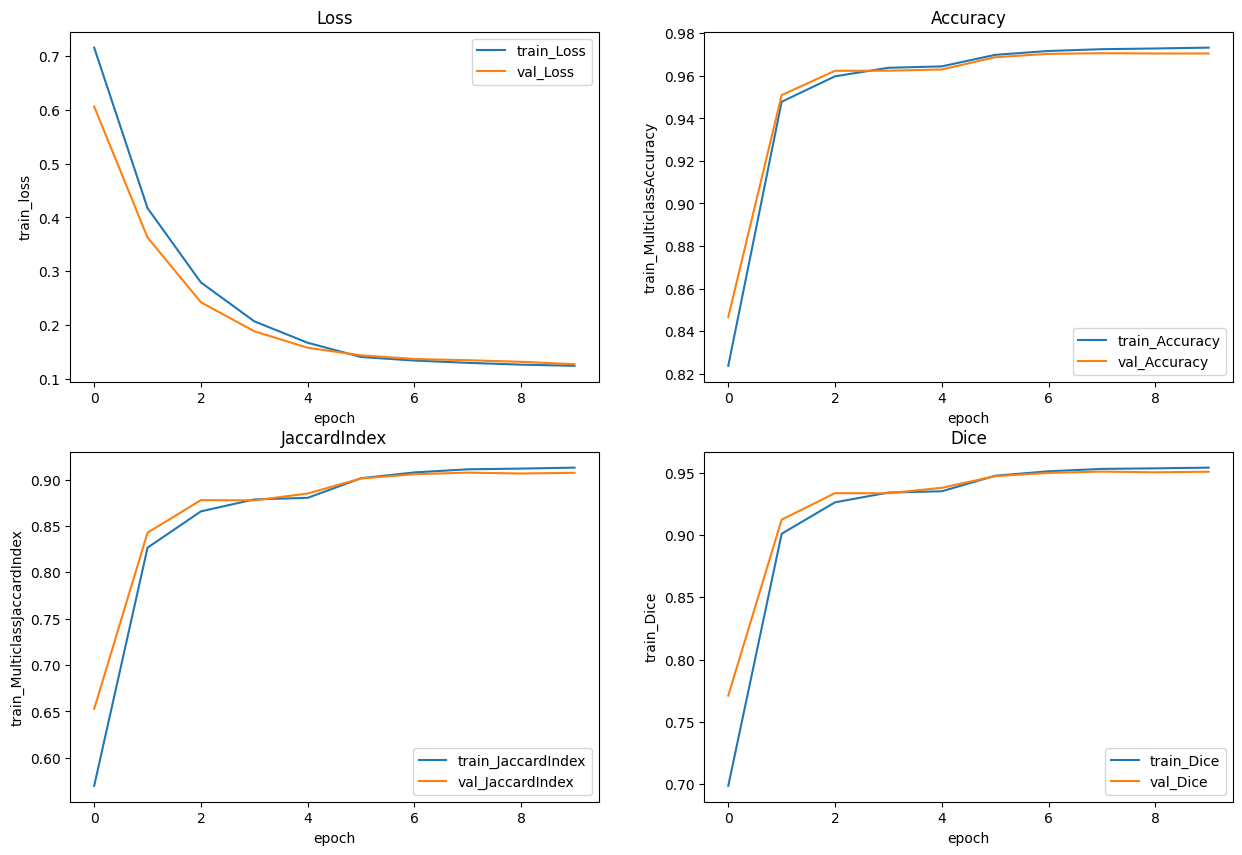

In [ ]:
def graph(metrics_df):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    sns.lineplot(data=metrics_df, x='epoch', y='train_loss', ax=ax[0, 0], label='train_Loss')
    sns.lineplot(data=metrics_df, x='epoch', y='val_loss', ax=ax[0, 0], label='val_Loss')
    ax[0, 0].set_title("Loss")
    ax[0, 0].legend()


    sns.lineplot(data=metrics_df, x='epoch', y='train_MulticlassAccuracy', ax=ax[0,1], label='train_Accuracy')
    sns.lineplot(data=metrics_df, x='epoch', y='val_MulticlassAccuracy', ax=ax[0,1], label='val_Accuracy')
    ax[0,1].set_title("Accuracy")
    ax[0,1].legend()

    sns.lineplot(data=metrics_df, x='epoch', y='train_MulticlassJaccardIndex', ax=ax[1,0], label='train_JaccardIndex')
    sns.lineplot(data=metrics_df, x='epoch', y='val_MulticlassJaccardIndex', ax=ax[1,0], label='val_JaccardIndex')
    ax[1,0].set_title("JaccardIndex")
    ax[1,0].legend()

    sns.lineplot(data=metrics_df, x='epoch', y='train_Dice', ax=ax[1,1], label='train_Dice')
    sns.lineplot(data=metrics_df, x='epoch', y='val_Dice', ax=ax[1,1], label='val_Dice')
    ax[1,1].set_title("Dice")
    ax[1,1].legend()
    plt.show()

graph(metrics_df)

Начало


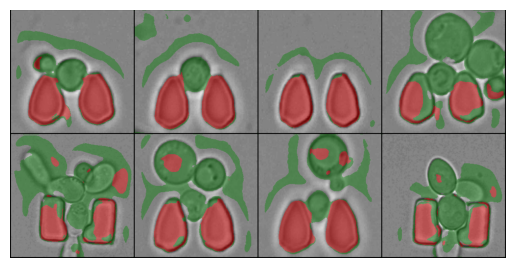

Середина


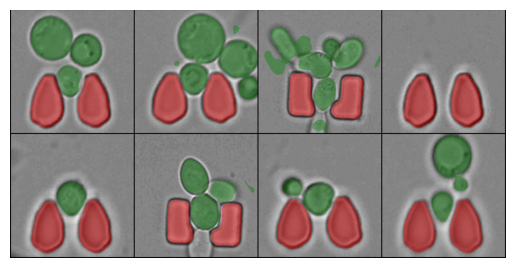

Конец


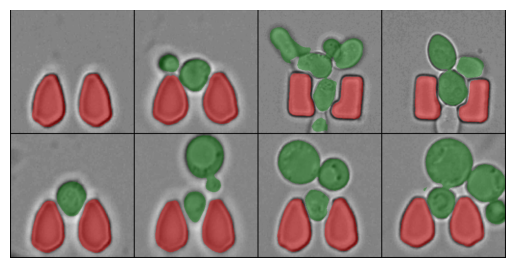

In [ ]:
import matplotlib.image as mpimg
def draw_images(output_dir):
    p0 = os.path.join(output_dir, f"epoch_0.png")
    p5 = os.path.join(output_dir, f"epoch_5.png")
    p9 = os.path.join(output_dir, f"epoch_9.png")

    print("Начало")
    img = mpimg.imread(p0)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print("Середина")
    img = mpimg.imread(p5)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print("Конец")
    img = mpimg.imread(p9)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

draw_images("./predictions/base/")

### Задание 3 (3 балла). Выбор другой функции ошибки

Полезная ссылка:
https://www.jeremyjordan.me/semantic-segmentation/#loss

Повторите эксперимент из задания 2, но попробуйте модифицировать функцию ошибки:
- (2 балла) учитывайте пиксели на границе объектов с большим весом, как предлагается в статье [U-Net](https://arxiv.org/abs/1505.04597)
- (1 балл) используйте soft Dice loss

Опишите свои наблюдения, что изменилось? Обратите внимание на скорость обучения, визуальные артефакты предсказаний, динамику метрик.


In [ ]:
def soft_dice_loss(y_pred, target, epsilon=1e-6):
    target = torch.nn.functional.one_hot(target.long(), num_classes=3).permute(0, 3, 1, 2)
    y_pred = F.log_softmax(y_pred)
    axes = tuple(range(1, len(y_pred.shape)-1))
    numerator = 2. * torch.sum(y_pred * target, axes)
    denominator = torch.sum(torch.square(y_pred) + torch.square(target), axes)

    return 1 - torch.mean((numerator + epsilon) / (denominator + epsilon))

In [ ]:
datamodule = Datamodule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    dataset_class=YeastSemanticSegmDataset,
    batch_size=8,
)

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    logger=L.pytorch.loggers.CSVLogger(save_dir=".", version = "dice"),
    callbacks=[SaveSegmentationPredictionsCallback("./predictions/dice")],
)
lit_module = Lit(
    model=UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True),
    learning_rate=0.001,
    loss_fn = soft_dice_loss,
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

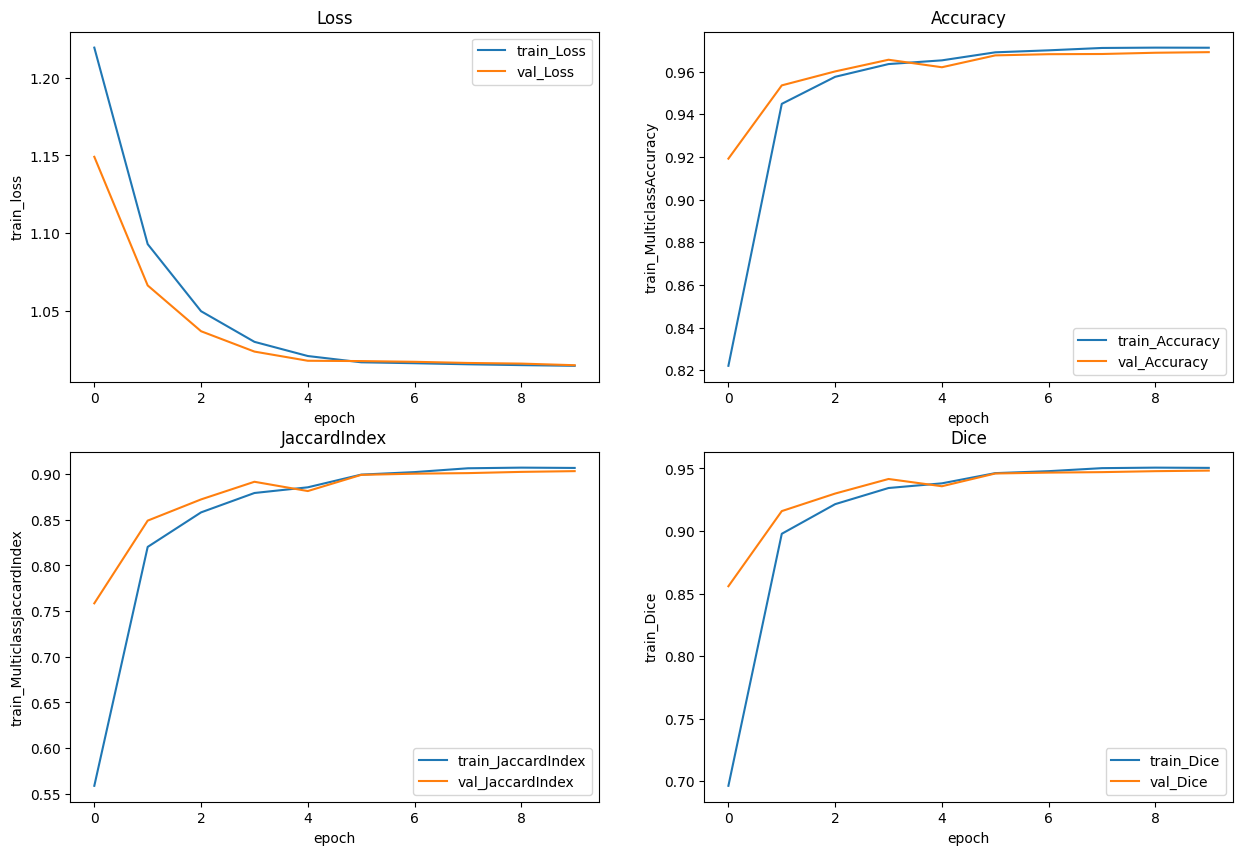

In [ ]:
dice_metrics_df = pd.read_csv(f"./lightning_logs/dice/metrics.csv")
graph(dice_metrics_df)

Начало


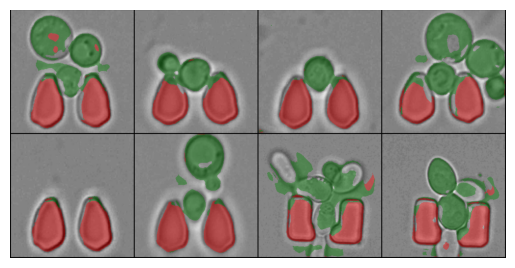

Середина


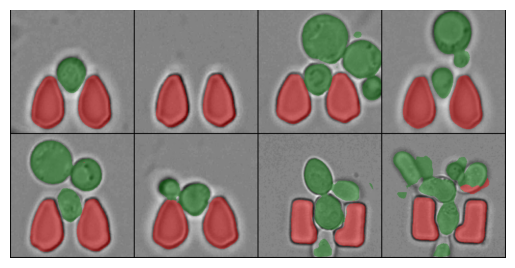

Конец


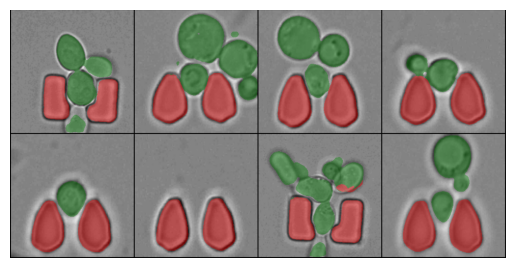

In [ ]:
draw_images("./predictions/dice/")

In [ ]:
from scipy.ndimage import distance_transform_edt
def weighted_bce_loss(y_pred, target, w0 = 10, sigma = 5):
    target = target.to('cpu')
    y_pred =  y_pred.to('cpu')
    dist1 = distance_transform_edt(target == 0)
    dist2 = distance_transform_edt(target == 1)

    dist1 = torch.from_numpy(dist1)
    dist2 = torch.from_numpy(dist2)

    weight_map = w0 * torch.exp(-(dist1 + dist2)**2 / (2 * sigma**2))

    ce_loss = F.nll_loss(F.log_softmax(y_pred.float(), dim=1), target, reduction='none')
    weighted_loss = ce_loss * weight_map

    return torch.mean(weighted_loss)

In [ ]:
datamodule = Datamodule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    dataset_class=YeastSemanticSegmDataset,
    batch_size=8,
)

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    logger=L.pytorch.loggers.CSVLogger(save_dir=".", version = "bce"),
    callbacks=[SaveSegmentationPredictionsCallback("./predictions/bce")],
)
lit_module = Lit(
    model=UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True),
    learning_rate=0.001,
    loss_fn = weighted_bce_loss,
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

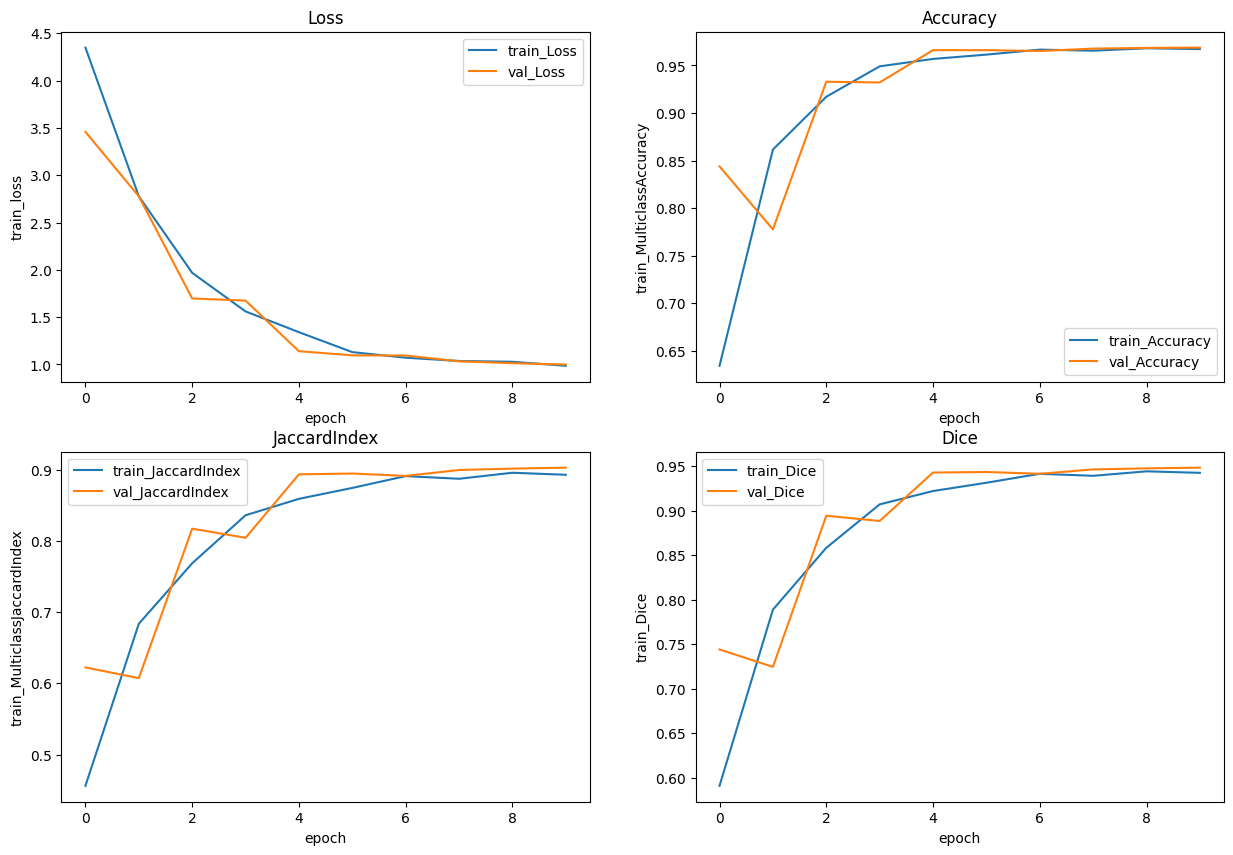

In [ ]:
bce_metrics_df = pd.read_csv(f"./lightning_logs/bce/metrics.csv")
graph(bce_metrics_df)

Начало


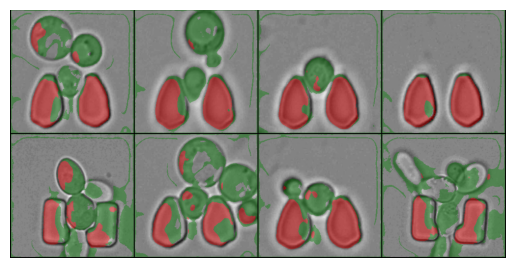

Середина


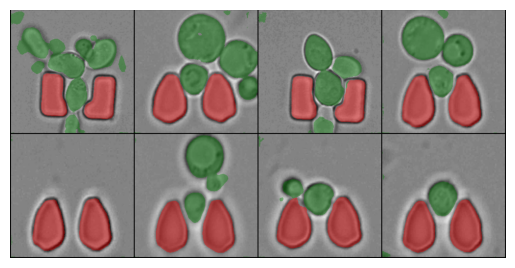

Конец


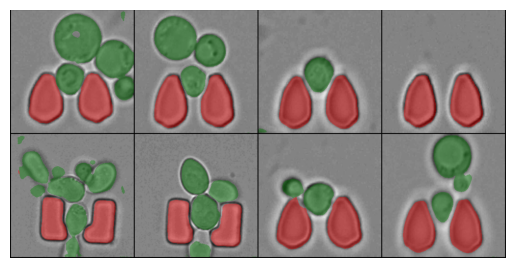

In [ ]:
draw_images("./predictions/bce/")

weighted_bce_loss заняло больше времени, чем cross_entropy_loss и dice_loss. сe_loss и dice_loss более гладкие, чем bce_loss (становится гадким в середине обучения). И bce_loss учиться медленее (в начале обучения метрики меньше, видны ловушки по краям).

### Задание 4 (3 балла). Модификация архитектуры

Ваша задача - извлечь максимальную точность из модели, в которой будет не более 50k параметров. Для этого внесите правки в архитектуру модели.

В частности, попробуйте заменить в блоке `Down` комбинацию conv+maxpool на dilated conv (`nn.Conv2d(..., dilation=2)`). В остальном - полная свобода творчества, можете перерабатывать архитектуру как угодно.

Как обычно, запустите эксперимент (или несколько) с выводом всех графиков и картинок.

In [ ]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=2,
            padding=2,
            dilation=2,
            bias=True,
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.conv(x)

In [ ]:
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    logger=L.pytorch.loggers.CSVLogger(save_dir=".", version = "new_model"),
    callbacks=[SaveSegmentationPredictionsCallback("predictions/new_model")],
)
lit_module = Lit(
    model=UNet(n_channels=1, n_classes=3, channel_sizes=[8, 16, 32, 64], bilinear=True),
    learning_rate=0.001,
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/usr/local/lib/python3.10/dist-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./lightning_logs/new_model exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./li

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


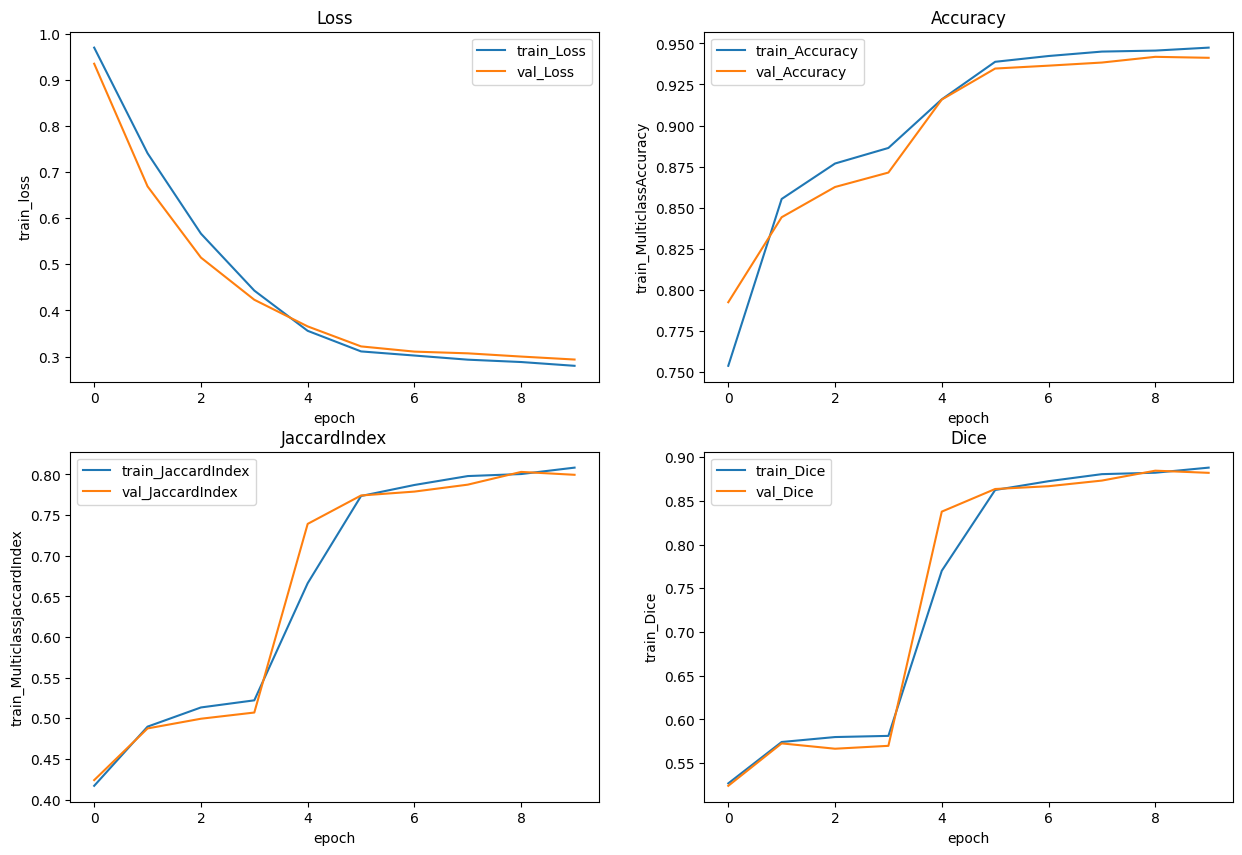

In [ ]:
new_model_metrics_df = pd.read_csv(f"./lightning_logs/new_model/metrics.csv")
graph(new_model_metrics_df)

Начало


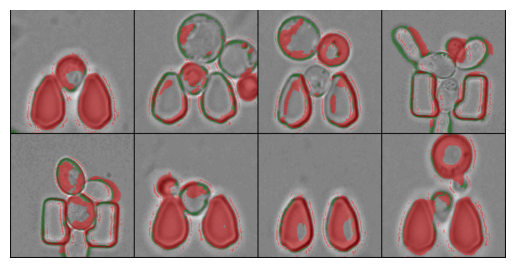

Середина


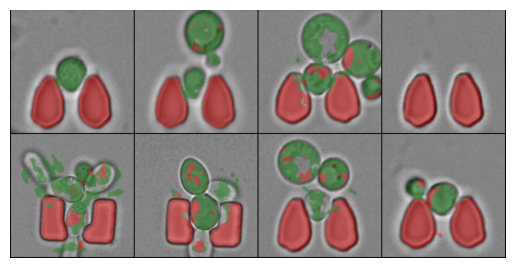

Конец


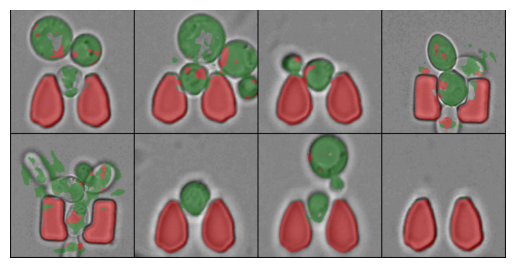

In [ ]:
draw_images("./predictions/new_model/")

Очевидно, что модель стала обучаться меньше времени, так как параметров меньше. При этом результат в конце обучения неплохой.